# Rates

## Discussion for Technical Interview Workshop
### Jan 10, 2022
### Relates to HW 8 Section 4 from FINM 36700-2021

## Areas of focus
- Working with the data
- Yields, returns, and forwards
- Expectations Hypothesis
- Factor structure

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.precision", 4)

import sys
sys.path.insert(0, '../cmds')
from portfolio import *

In [2]:
DATAPATH = '../data/treasury_data.xlsx'
SHEET = 'prices'
prices = pd.read_excel(DATAPATH,sheet_name=SHEET).set_index('date')

In [3]:
SHEET = 'yields'
yields = pd.read_excel(DATAPATH,sheet_name=SHEET).set_index('date')

In [4]:
prices.tail()

,1,2,3,4,5
date,,,,,
2021-06-30,0.9991,0.9950,0.9863,0.9727,0.9561
2021-07-30,0.9994,0.9965,0.9897,0.9782,0.9657
2021-08-31,0.9991,0.9957,0.9876,0.9752,0.9616
2021-09-30,0.9992,0.9945,0.9851,0.9693,0.9523
2021-10-29,0.9985,0.9899,0.9773,0.9595,0.9426


In [5]:
yields.head()

,1,2,3,4,5
date,,,,,
1952-06-30,0.0184,0.0191,0.0198,0.0191,0.0202
1952-07-31,0.0192,0.0203,0.0209,0.0200,0.0214
1952-08-29,0.0195,0.0205,0.0214,0.0204,0.0220
1952-09-30,0.0199,0.0209,0.0215,0.0206,0.0229
1952-10-31,0.0191,0.0206,0.0215,0.0210,0.0217


In [6]:
yields.tail()

,1,2,3,4,5
date,,,,,
2021-06-30,0.0009,0.0025,0.0046,0.0069,0.0090
2021-07-30,0.0006,0.0017,0.0034,0.0055,0.0070
2021-08-31,0.0009,0.0021,0.0041,0.0063,0.0078
2021-09-30,0.0008,0.0028,0.0050,0.0078,0.0098
2021-10-29,0.0015,0.0051,0.0076,0.0103,0.0118


## Reminder on Prices and Yields

Define the Price of the $n$-maturity bond as $P^{(n)}$.

Define the log yield as
$$\texttt{y}^{(n)} \equiv \ln\left(1+y^{(n)}\right)$$

Define the log price as
$$\texttt{p}^{(n)} \equiv \ln\left(P^{(n)}\right)$$

#### In levels
$$P = \frac{1}{(1+y)^n}$$
Thus,
$$y^{(n)} = \left(\frac{1}{P^{(n)}}\right)^{\frac{1}{n}} - 1$$

#### In logarithms
$$\texttt{p}^{(n)} = -n\, \texttt{y}^{(n)}$$

$$\texttt{y}^{(n)} = -\frac{1}{n}\texttt{p}^{(n)}$$

### The data provided here is in levels
- `prices` are $P^{(n)}$
- `yields` are $y^{(n)}$

We will find it more convenient to use logs for both.
- The price and yield data has small inconsistencies.
- Accordingly, we use the prices data and then infer the yields computationally

In [7]:
lprices = np.log(prices)
lprices.columns.name = 'Maturity'
lprices.index.name = 'Log Prices'

lyields = (- lprices / (lprices.columns.values)).astype('float64')
lyields.index.name = 'Log Yields'

### Data Note: Why are we only using maturities through 5 years?

Obviously there is no traded treasury that has a constant maturity of 1 year, 2 years, etc.

But for analysis, we would like an index showing the pricing of these maturities at any given date.

Building this index requires care, with rules on which issue of treasury to use as being closest to that maturity.

#### These are known as Constant Maturity Treasuries (CMT) - they are an index
- The most popular for research purposes are the Fama-Bliss construction. 
- You can download it from WRDS
- Other series will give similar results for our work below!

# Summaries on Prices and Yields

In [8]:
def summary_data(data):
    tab = data.mean().to_frame()
    tab.columns=['Mean']
    tab['Vol'] = data.std()
    display(tab)
    
    display(data.plot(figsize=(10,5),title=data.index.name))

,Mean,Vol
Maturity,,
1,0.0457,0.0322
2,0.0477,0.0318
3,0.0495,0.0312
4,0.0510,0.0307
5,0.0521,0.0301


<AxesSubplot:title={'center':'Log Yields'}, xlabel='Log Yields'>

,Mean,Vol
Maturity,,
1,-0.0457,0.0322
2,-0.0953,0.0637
3,-0.1484,0.0937
4,-0.2039,0.1228
5,-0.2603,0.1505


<AxesSubplot:title={'center':'Log Yields'}, xlabel='Log Yields'>

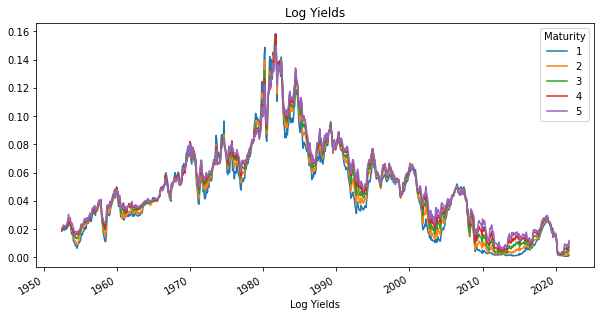

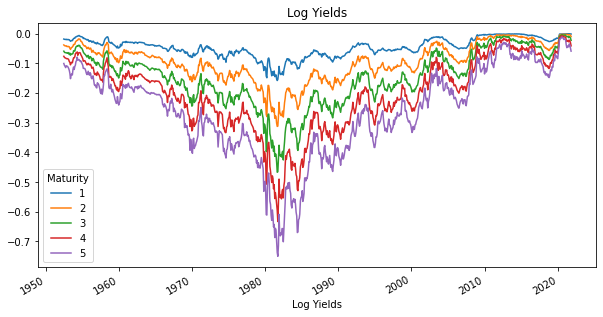

In [9]:
summary_data(lyields)
summary_data(lprices)

# Forward Rate Summary

Recall that the log forward rate is defined as the difference--across maturities, not time--of the log prices:
$$\texttt{f}_t^{(n\to n+1)} \equiv \texttt{p}^{(n)}_t - \texttt{p}^{(n+1)}_t$$

For $n=0$, the log forward is simply:
$$\texttt{f}_t^{(0\to 1)} \equiv \texttt{p}^{(0)}_t - \texttt{p}^{(1)}_t =  - \texttt{p}^{(1)}_t =  \texttt{y}^{(1)}_t$$

,Mean,Vol
Maturity,,
1,0.0457,0.0322
2,0.0496,0.0319
3,0.0530,0.0305
4,0.0555,0.0298
5,0.0564,0.0285


<AxesSubplot:title={'center':'Log Forwards'}, xlabel='Log Forwards'>

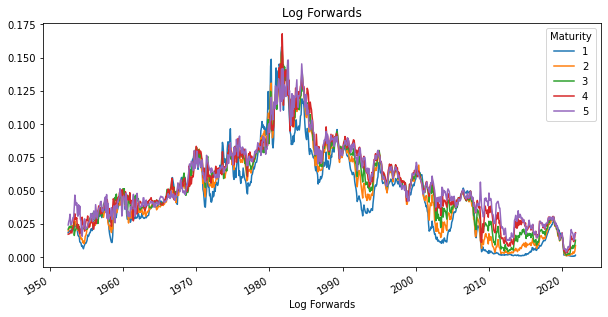

In [10]:
lforwards = -lprices.diff(axis=1)
lforwards[1] = -lprices[1]
lforwards.index.name = 'Log Forwards'

summary_data(lforwards)

# Return Summary

In [11]:
FREQ = 12

lrets = pd.DataFrame(columns=lprices.columns, index=lprices.index)
lrets.index.name = 'Log Returns'
lrets[1] = lyields[1].shift(FREQ)

for n in range(2,6):
    lrets[n] = lprices[n-1] - lprices[n].shift(FREQ)

lrets.dropna(inplace=True)

lretsx = lrets.subtract(lrets[1],axis=0).drop(columns=[1])
performanceMetrics(lretsx,annualization=1)

,Mean,Vol,Sharpe,Min,Max
Maturity,,,,,
2,0.0042,0.0158,0.2629,-0.0559,0.0597
3,0.0079,0.0290,0.2716,-0.1043,0.1026
4,0.0106,0.0404,0.2614,-0.1355,0.1438
5,0.0115,0.0501,0.2302,-0.1755,0.1689


#### Correlation of excess returns by maturity

In [12]:
lretsx.corr()

Maturity,2,3,4,5
Maturity,,,,
2,1.0000,0.9800,0.9581,0.9350
3,0.9800,1.0000,0.9886,0.9737
4,0.9581,0.9886,1.0000,0.9916
5,0.9350,0.9737,0.9916,1.0000


## The Expectations Hypothesis

The statistics above are evidence against the Expectations Hypothesis. Specifically,
- The EH states average short-term yields equal average long-term yields. Above we saw that is not the case.
- The EH states that all maturities have the same average one-period returns. .But above we see higher average returns for the longer-maturity bonds. Given that we are looking at excess returns, EH states the means should be 0, but they are positive and increasing with the maturity.

## Testing the Expectations Hypothesis

The EH says that 
- nothing should be able to predict returns on bonds (of any maturity $n$.) 
- nothing should be able to predict *excess* returns on bonds, which should have an expectation of 0.

To test this, we could try using the forward rate as a lagged regressor in a forecasting regression targeting returns:

We will get better statistical power by subtracting the one-period yield from both sides. Thus, we will predict *excess* returns with the forward *spread*. For any maturity $n=2\ldots$:
$$\texttt{r}^{(n)}_{t+12} - \texttt{y}^{(1)}_{t} = \alpha + \beta\, \left(\texttt{f}^{(n\to n+1)}_t -  \texttt{y}^{(1)}_{t}\right) + \epsilon_{t+1}$$

### The Forward Spread
Notate the forward spread with a tilde, given that it is a forward minus the $0\to 1$ forward, analagous to how we use tilde to denote excess returns.
$$\tilde{\texttt{f}}^{(n\to n+1)}_t \equiv \texttt{f}^{(n\to n+1)}_t - \texttt{f}^{(0\to 1)}_t$$
Recall that 
$$\texttt{f}^{(0\to 1)}_t = \texttt{y}^{(1)}_t = \texttt{r}^{(1)}_{t+1}$$

Thus, we can also write the forward spread as the spread relative to the $n=1$ yield:
$$\tilde{\texttt{f}}^{(n\to n+1)}_t \equiv \texttt{f}^{(n\to n+1)}_t - \texttt{y}^{(1)}_t$$

### The Regression
We can then notate the forecasting regression as
$$\tilde{\texttt{r}}^{(n)}_{t+12} = \alpha + \beta \tilde{\texttt{f}}^{(n\to n+1)}_t + \epsilon_{t+1}$$

### EH Implications
- The EH says *no regressor* should work in this forecasting regression. 
- So in this regression specifically, it implies we should find a $\beta$ of zero (up to statistical error.) 
- It has no implication for the R-squared.
- The strongest version of EH says $\alpha$ should be 0, as mean excess returns should be 0. A weaker, more general version would allow an $\alpha$ but would still imply $\beta=0$.

In [13]:
lforwardsx = lforwards.subtract(lforwards[1],axis=0).drop(columns=[1])

EHtest = pd.DataFrame(index=lretsx.columns, columns=['alpha','beta','r-squared'])

for n in range(2,6):
    X = lforwardsx.shift(FREQ).dropna()[[n]]
    y = lretsx[[n]]
    
    mod = LinearRegression().fit(X,y)
    EHtest.loc[n,'alpha'] = mod.intercept_[0]
    EHtest.loc[n,'beta'] = mod.coef_[0,0]
    EHtest.loc[n,'r-squared'] = mod.score(X,y)

#EHtest.style.set_caption('Predicting $\\tilde{r}^{(n)}$ with the $n\\to n+1$ forward spread.')
EHtest.style.set_caption('$$\\tilde{r}^{(n)}_{t+1} = \\alpha^{(n)} + \\beta^{(n)}\\tilde{f}^{(n \\to n+1)}_t + \epsilon^{(n)}_{t+1}$$').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '14px')
    ]
}])

,alpha,beta,r-squared
Maturity,,,
2,0.0014,0.7212,0.0863
3,0.0010,0.9424,0.0943
4,-0.0010,1.1862,0.1183
5,0.0012,0.9792,0.0665


### Evidence Against the EH
- EH says expected returns (nor excess returns) should be predictable.
- But our regression shows non-zero beta when using forward-spread as a predictor of excess returns.
- Of course, we could have tried other predictors, but the forward spread seems to work, and EH says *nothing* should work as a regressor.

The predictability power is modest; the r-squared is positive for each maturity, but not by a lot. It is a further question to see if this predictability holds up Out-of-Sample.

Though again, we could try many other predictors, or multiple predictors. We are not restricted to using the matching-maturity forward spread. But as the lecture suggested, the forward spread is showing predictive power. 

## Testing the Forward as Optimal Predictor of Yields
### Extension: this problem was not listed.

EH makes three statements:
1. In expectation, the yield curve is flat. That is, expected long-maturity yields are not larger than expected short-maturity yields. **Results in 4.1 show this is false.**

1. Expected returns on holding bonds are equal across maturities. And expected excess returns on bonds are zero. **Results in 4.5 show this is false.**

1. Forward rates are the optimal forecast of future (one-period) yields. **We test this idea in this problem by running a forecasting regression.**

$$\mathbb{E}_t\left[\texttt{y}^{(1)}_{t+n}\right] = \texttt{f}_t^{(n\to n+1)}$$
We could test this by regressing $\texttt{y}^{(1)}_{t+12n}$ on $\texttt{f}_t^{(n\to n+1)}$. However, we get better statistical power by subtracting the $n=1$ yield, (which is also the $0\to 1$ forward,) from both sides.

$$\texttt{y}^{(1)}_{t+12n} - \texttt{y}^{(1)}_{t} = \alpha + \beta\, \left(\texttt{f}^{(n\to n+1)}_t -  \texttt{y}^{(1)}_{t}\right) + \epsilon_{t+1}$$

which using our excess forward rate notation, is equivalent to
$$\texttt{y}^{(1)}_{t+12n} - \texttt{y}^{(1)}_{t} = \alpha + \beta\, \tilde{\texttt{f}}^{(n\to n+1)}_t + \epsilon_{t+1}$$

In [14]:
lyields_growth = lyields.diff(FREQ)

forecast_yields = pd.DataFrame(index=lretsx.columns, columns=['alpha','beta','r-squared'])

for n in range(2,6):
    X = lforwardsx.shift(FREQ*(n-1))[[n]].dropna()
    y = lyields_growth[[1]].dropna()
    
    X, y = X.align(y,join='inner',axis=0)
    
    mod = LinearRegression().fit(X,y)
    forecast_yields.loc[n,'alpha'] = mod.intercept_[0]
    forecast_yields.loc[n,'beta'] = mod.coef_[0,0]
    forecast_yields.loc[n,'r-squared'] = mod.score(X,y)

forecast_yields.style.set_caption('$$y^{(1)}_{t+n}-y^{(1)}_t = \\alpha^{(n)} + \\beta^{(n)}\\left(f^{(n \\to n+1)}_t -y^{(1)}_t\\right)+ \epsilon^{(n)}_{t+n}$$').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '14px')
    ]
}])

,alpha,beta,r-squared
Maturity,,,
2,-0.0014,0.2788,0.0139
3,-0.0032,0.3984,0.0609
4,-0.0035,0.3362,0.0664
5,-0.0016,0.1104,0.0092


### Results
- The forward spreads have small beta in predicting the future one-year yield growth.
- EH implied beta would have been nearly 1 for each maturity. Instead, it is closer to 0.
- Thus, we see higher forward rates do not predict higher yields--they predict higher returns.

***

# PCA

Recall construction of principal component factors.
- Statistically extracted factors from covariance matrix.
- First factor is linear combination of data which explains
maximum amount of variance.
- Second factor maximizes variance conditional on being orthogonal to the first factor.
- And so on. Can extract same number of factors as number of data series.

In [15]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='full')

In [16]:
pca.fit(lyields)
pca_wts = pd.DataFrame(pca.components_,columns=lyields.columns.copy(),index=lyields.columns.copy())
pca_wts.index.name = 'PCA'

In [17]:
var_explained = pd.DataFrame(pca.explained_variance_ratio_,index=pca_wts.index,columns=['yields'])
var_explained.style.format('{:.2%}'.format)

,yields
PCA,
1,99.24%
2,0.71%
3,0.03%
4,0.01%
5,0.01%


### Factor Structure!

Most the variation is a single factor!

We only have 5 series, but even if we had 50 or 500, we'd see that the vast majority of variation is explained by the first three factors.

#### And obviously, this structure will show up in (log) forwards and (log) returns as well.
You could verify that they also show up in levels, (not logs.)

In [18]:
pca.fit(lretsx)
var_explained.loc[:4,'returns'] = pca.explained_variance_ratio_

pca.fit(lforwardsx)
var_explained.loc[:4,'forwards'] = pca.explained_variance_ratio_

var_explained.style.format('{:.2%}'.format)

,yields,returns,forwards
PCA,,,
1,99.24%,98.78%,90.12%
2,0.71%,0.98%,5.63%
3,0.03%,0.15%,2.73%
4,0.01%,0.08%,1.52%
5,0.01%,nan%,nan%


#### What are these factors? 

PCA does not return named (structured) factors. 

But with rates, we often see they are interpretable.

Let's look at the weights.

In [19]:
pca_wts

Maturity,1,2,3,4,5
PCA,,,,,
1,0.4583,0.4574,0.4489,0.4404,0.4304
2,0.7257,0.2265,-0.1102,-0.3621,-0.5280
3,0.4717,-0.4996,-0.4787,-0.0179,0.5463
4,0.1928,-0.6111,0.3065,0.5504,-0.4387
5,0.0602,-0.3412,0.6806,-0.6096,0.2123


### PCA Weights

The weights above show how the PCA factor loads on each maturity.

The PCA weights are typically not interpretable, but for rates, they often are.

We see
- Level
- Slope
- Curvature

To better see this, re-scale the second and third PCA factor by negative 1. (This makes no difference--think of eigenvectors and eigenvalues.)

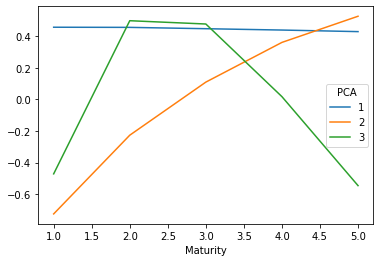

In [20]:
pca_wts.loc[2:3,:] *= -1
pca_wts.T[[1,2,3]].plot();

***

# Try Using Different Data

Fed Reserves yield data by Gurkaynak, Sack, and Wright.
- 30 years of CMT
- Modeled yields, so could argue about accuracy.

Import via NASDAQ (Quandl) or get directly from the FRB.\
https://data.nasdaq.com/data/FED/SVENY-us-treasury-zerocoupon-yield-curve
https://www.federalreserve.gov/pubs/feds/2006/200628/200628abs.html

In [21]:
import quandl
file_key = open("../../../keys/quandl_key.txt","r")
API_KEY = file_key.read()
file_key.close()

quandl.ApiConfig.api_key = API_KEY
svenyields = quandl.get("FED/SVENY")
svenyields.dropna(inplace=True)
svenyields.columns = svenyields.columns.str.replace("SVENY", "")
svenyields.columns.name = 'Maturity'

### Variance explained by PCAs?

Differs from above
- Daily data
- Level yields, not log yields
- Yields calculated from different methodology

In [22]:
pca.fit(svenyields)
pd.DataFrame(pca.explained_variance_ratio_[0:3],columns=['Variance explained']).style.format('{:.2%}'.format)

,Variance explained
0,97.15%
1,2.62%
2,0.15%


- Still get the same conclusion!

- Also for the PCA loading shapes.

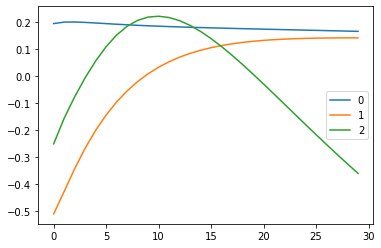

In [23]:
pca_wts = pd.DataFrame(pca.components_)
pca_wts.T.iloc[:,0:3].plot();

#### Same Factor Structure in PCAs!

Display yield curves from various dates. 
- Differing shapes
- Upward or downward sloping
- These are modeled, explaining smooth interpolation.
- For strange shapes, look at scale on y-axis and notice essentially flat.

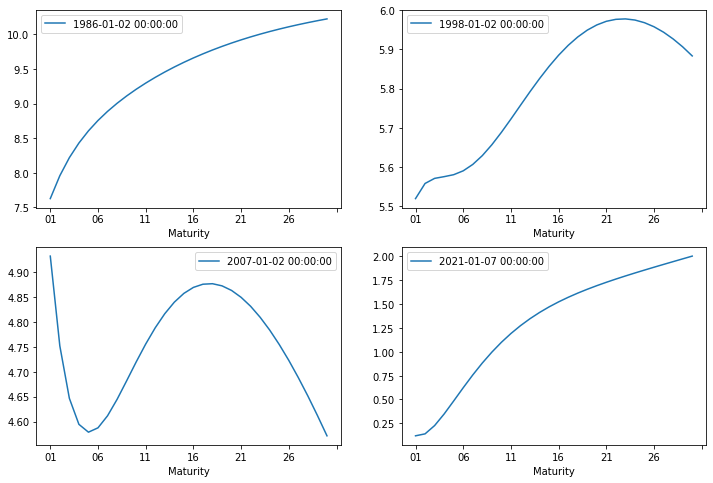

In [24]:
dts = ['1986-01-02','1998-01-02','2007-01-02','2021-01-07']
plotrows = -(-len(dts)//2)

for i, dt in enumerate(dts):
    plt.subplot(plotrows,2,i+1)
    svenyields.loc[dt,:].T.plot(figsize=(12,plotrows*4))

    plt.legend()